Here's a introductive LightGBM model used for predicting correct answers.
For some memory issues faced with pandas library, it would be a nice idea to try datatable library known for speed and big data support which uses less memory, for more information about it you can read the following datatable documentation: https://datatable.readthedocs.io/en/latest/start/quick-start.html

In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


In [2]:
import pandas as pd
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt

In [3]:
features =  ['user_id', 'content_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv').to_pandas()
train_df = train_df[features]

In [4]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,NaN
1,115,5716,1,37000.0,False
2,115,128,1,55000.0,False
3,115,7860,1,19000.0,False
4,115,7922,1,11000.0,False


# Preprocessing
Let's add some preprocessing to add more information and features to the training dataset

In [5]:
train_df['answered_correctly'].unique()

array([ 1,  0, -1], dtype=int32)

As you see in this column 'answered_correctly' there are some indesired values which add noise to the data as well as for the predicted results of the model so it's a good habit to get rid of all empty and inapropriate values within the columns that we need for

In [6]:
#Eliminate rows with -1 values in the target
train_df = train_df[train_df['answered_correctly'] != -1].reset_index(drop=True)
#Replace null values with FALSE
train_df.fillna(False, inplace=True)

train_df['user_id'] = train_df['user_id'].astype('int32')
train_df['content_id'] = train_df['content_id'].astype('int16')
train_df['answered_correctly'] = train_df['answered_correctly'].astype('int8')
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].astype('float32')
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype('bool')

In [7]:
train_df['user'] = train_df.groupby('user_id')['answered_correctly'].shift()
#Calculate ratio of correct answers of the whole answers provided by the user
cumulated = train_df.groupby('user_id')['user'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cumulated['cumsum'] / cumulated['cumcount']
train_df.drop(columns=['user'], inplace=True)

In [8]:
user_agg = train_df.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')['answered_correctly'].agg(['sum', 'count'])

In [9]:
train_df = train_df.groupby('user_id').tail(60).reset_index(drop=True)

In [10]:
questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')[['question_id', 'part']]
questions_df['question_id'] = questions_df['question_id'].astype('int16')
questions_df['part'] = questions_df['part'].astype('int8')

train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [11]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [12]:
valid_df = train_df.groupby('user_id').tail(15)
train_df.drop(valid_df.index, inplace=True)

In [13]:
train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
0,115,0.745495,1,0.0,False,NaN,5,36514
1,115,0.734901,1,37000.0,False,1.0,5,23991
2,115,0.966869,1,55000.0,False,1.0,1,19619
3,115,0.954815,1,19000.0,False,1.0,1,21733
4,115,0.953218,1,11000.0,False,1.0,1,19409


# The LightGBM model and training process

In [14]:
#Defining the features to consider after feature engineering
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

target = 'answered_correctly'

In [15]:
#Defining LightGBM parameters
params = {
    'objective': 'binary',
    #'tree_method': 'hist'
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 100
}

In [16]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

#Training of the model
model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

#If you want to save the model
# model.save_model(f'model.txt')

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.751411	valid_1's auc: 0.740104
[100]	training's auc: 0.752741	valid_1's auc: 0.741721
[150]	training's auc: 0.753306	valid_1's auc: 0.742315
[200]	training's auc: 0.753623	valid_1's auc: 0.742546
[250]	training's auc: 0.753877	valid_1's auc: 0.74271
[300]	training's auc: 0.754082	valid_1's auc: 0.742809
[350]	training's auc: 0.75429	valid_1's auc: 0.742914
[400]	training's auc: 0.75448	valid_1's auc: 0.743007
[450]	training's auc: 0.754673	valid_1's auc: 0.743096
[500]	training's auc: 0.754835	valid_1's auc: 0.743145
[550]	training's auc: 0.754984	valid_1's auc: 0.743189
[600]	training's auc: 0.755143	valid_1's auc: 0.743235
[650]	training's auc: 0.755295	valid_1's auc: 0.74327
[700]	training's auc: 0.755439	valid_1's auc: 0.743296
[750]	training's auc: 0.75559	valid_1's auc: 0.743331
[800]	training's auc: 0.755734	valid_1's auc: 0.743355
[850]	training's auc: 0.755865	valid_1's auc: 0.743376
[900]	trai

To see how the features selected to the training are valuable it would be nice to plot their importance for the predicition of the correctness of each user's answer

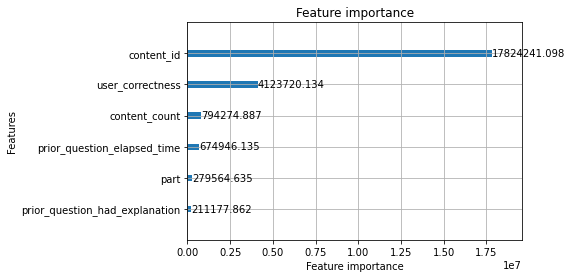

In [17]:
lgb.plot_importance(model, importance_type='gain')
plt.show()

# Testing the model via EducationRiid library

In [18]:
import riiideducation

In [19]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [20]:
for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            if user_id in user_agg.index:
                user_agg.loc[user_id, 'sum'] += answered_correctly
                user_agg.loc[user_id, 'count'] += 1
            else:
                user_agg.loc[user_id] = [answered_correctly, 1]
            
            if content_id in content_agg.index:
                content_agg.loc[content_id, 'sum'] += answered_correctly
                content_agg.loc[content_id, 'count'] += 1
            else:
                content_agg.loc[content_id] = [answered_correctly, 1]
                
    prior_test_df = test_df.copy()
    
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    test_df['user_correctness'] = test_df['user_id'].map(user_agg['sum'] / user_agg['count'])
    
    test_df['content_count'] = test_df['content_id'].map(content_agg['count']).fillna(1)
    test_df['content_id'] = test_df['content_id'].map(content_agg['sum'] / content_agg['count']).fillna(0.7)
      
    test_df['answered_correctly'] = model.predict(test_df[features])
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

# Conclusion 

The model is showing a very important precision results but due to the large dataset it's impossible to train it with other features from the proposed datasets (train, question and lectures) also it's only trained on a part of the users (not all of them).
Maybe it would beneficial to use more hardware resources (RAM !!!) in order to get higher performances.